In [126]:
import os
import time

import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import lightgbm as lgb
import shap
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, \
    accuracy_score, precision_score, recall_score, f1_score

## 1. Data Loading

In [127]:
path = 'data/loan_classification/loan.csv'
df = pd.read_csv(path, low_memory=False)
df.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   
3  1076863    1277178      10000        10000          10000.0   36 months   
4  1075358    1311748       3000         3000           3000.0   60 months   

  int_rate  installment grade sub_grade  ... num_tl_90g_dpd_24m  \
0   10.65%       162.87     B        B2  ...                NaN   
1   15.27%        59.83     C        C4  ...                NaN   
2   15.96%        84.33     C        C5  ...                NaN   
3   13.49%       339.31     C        C1  ...                NaN   
4   12.69%        67.79     B        B5  ...                NaN   

  num_tl_op_past_12m pct_tl_nvr_dlq  percent_bc_gt_75 pub_rec_bankruptcies  \
0                NaN            NaN               NaN                  0.0   
1                NaN            NaN               NaN                  0.0   
2                NaN            NaN               NaN                  0.0   
3                NaN            NaN               NaN                  0.0   
4                NaN            NaN               NaN                  0.0   

  tax_liens tot_hi_cred_lim total_bal_ex_mort total_bc_limit  \
0       0.0             NaN               NaN            NaN   
1       0.0             NaN               NaN            NaN   
2       0.0             NaN               NaN            NaN   
3       0.0             NaN               NaN            NaN   
4       0.0             NaN               NaN            NaN   

  total_il_high_credit_limit  
0                        NaN  
1                        NaN  
2                        NaN  
3                        NaN  
4                        NaN  

[5 rows x 111 columns]

## 2. Data Understanding & Cleaning

### Mô tả dữ liệu

In [128]:
def check_df(dataframe, head=5):
    print(" SHAPE ".center(70, '-'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" TYPES ".center(70, '-'))
    print(dataframe.dtypes)
    print(" HEAD ".center(70, '-'))
    print(dataframe.head(head))
    print(' TAIL '.center(70, '-'))
    print(dataframe.tail(head))
    print(' MISSING VALUES '.center(70, '-'))
    print(dataframe.isnull().sum())
    print(' DUPLICATED VALUES '.center(70, '-'))
    print(dataframe.duplicated().sum())


check_df(df)

------------------------------- SHAPE --------------------------------
Rows: 39717
Columns: 111
------------------------------- TYPES --------------------------------
id                              int64
member_id                       int64
loan_amnt                       int64
funded_amnt                     int64
funded_amnt_inv               float64
                               ...   
tax_liens                     float64
tot_hi_cred_lim               float64
total_bal_ex_mort             float64
total_bc_limit                float64
total_il_high_credit_limit    float64
Length: 111, dtype: object
-------------------------------- HEAD --------------------------------
        id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   
3  10

In [129]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # Giới hạn (Threshold) cho số giá trị duy nhất (unique value) để được coi là 1 biến categorical (cat) hoặc high-carndinality categorical (car)
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'Categorical Columns: {len(cat_cols)}')
    print(f'Numerical Columns: {len(num_cols)}')
    print(f'Categorical but cardinal: {len(cat_but_car)}')
    print(f'Numerical but categorical: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=10)
print(cat_cols, num_cols, cat_but_car, sep='\n')

Observations: 39717
Variables: 111
Categorical Columns: 70
Numerical Columns: 26
Categorical but cardinal: 15
Numerical but categorical: 61
['term', 'grade', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'initial_list_status', 'next_pymnt_d', 'application_type', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [131]:
sum = 0
for column in df.columns:
    if df[column].isnull().sum() > 0:
        sum += 1

print('Features that have missing values:', sum)

Features that have missing values: 68


**Nhận xét nhanh:**

*  Bộ dữ liệu có 39,717 quan trắc, có 110 biến đặc trưng và 1 biến mục tiêu `loan_status`.
*  Bộ dữ liệu có 110 biến đặc trưng (feature) nhưng lại có tới 68 biến bị khuyết giá trị. Bởi vì lượng dữ liệu bị khuyết lớn nên ta phải xử lý các biến bị khuyết này thật cẩn thận để tránh bị mất mát quá nhiều thông tin.
*  Bộ dữ liệu có 70 biến categorical và 24 biến có kiểu dữ liệu là object (string). Nếu muốn sử dụng các biến này với các mô hình truyền thống, đơn giản như Logistic Regression sẽ cần phải xử lý, encode cẩn thận.

### Làm sạch dữ liệu

#### Loại bỏ biến không sử dụng

**Loại bỏ các biến Entity.**

In [132]:
df.drop(['id', 'member_id'], axis=1, inplace=True)

**Loại bỏ các biến NULL.**

In [133]:
for column in df.columns:
    if df[column].isnull().sum() == df.shape[0]:
        df.drop([column], axis=1, inplace=True)

**Loại bỏ các biến không có ý nghĩa.**

In [134]:
df_describe = df.describe().T
df_describe[(df_describe['min'] == 0) & (df_describe['max'] == 0)]

count  mean  std  min  25%  50%  75%  max
collections_12_mths_ex_med  39661.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
acc_now_delinq              39717.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
chargeoff_within_12_mths    39661.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
delinq_amnt                 39717.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
tax_liens                   39678.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [135]:
df['pymnt_plan'].value_counts()

pymnt_plan
n    39717
Name: count, dtype: int64

In [136]:
df['initial_list_status'].value_counts()

initial_list_status
f    39717
Name: count, dtype: int64

In [137]:
df['application_type'].value_counts()

application_type
INDIVIDUAL    39717
Name: count, dtype: int64

In [138]:
df['url'].value_counts()

url
https://lendingclub.com/browse/loanDetail.action?loan_id=1077501    1
https://lendingclub.com/browse/loanDetail.action?loan_id=568534     1
https://lendingclub.com/browse/loanDetail.action?loan_id=568659     1
https://lendingclub.com/browse/loanDetail.action?loan_id=567165     1
https://lendingclub.com/browse/loanDetail.action?loan_id=568531     1
                                                                   ..
https://lendingclub.com/browse/loanDetail.action?loan_id=785667     1
https://lendingclub.com/browse/loanDetail.action?loan_id=785659     1
https://lendingclub.com/browse/loanDetail.action?loan_id=785630     1
https://lendingclub.com/browse/loanDetail.action?loan_id=785626     1
https://lendingclub.com/browse/loanDetail.action?loan_id=87023      1
Name: count, Length: 39717, dtype: int64

In [139]:
df['desc'].value_counts()

desc
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           210
Debt Consolidation                                                                                                                                                                  

In [140]:
df['title'].value_counts()

title
Debt Consolidation                  2184
Debt Consolidation Loan             1729
Personal Loan                        659
Consolidation                        517
debt consolidation                   505
                                    ... 
your rate is better than my rate       1
Concession Trailer                     1
gregs                                  1
EZover                                 1
JAL Loan                               1
Name: count, Length: 19615, dtype: int64

**Nhận xét nhanh:**

*  Các biến `collections_12_mths_ex_med`, `acc_now_delinq`, `chargeoff_within_12_mths`, `delinq_amnt`, `tax_liens` đều có toàn bộ giá trị bằng 0 nên ta sẽ loại bỏ vì không mang lại thông tin.
*  Các biến `pymnt_plan`, `initial_list_status`, `application_type` đều có toàn bộ giá trị giống nhau. Điều này khiến các biến trên không mang lại thông tin gì hữu ích cho việc giải bài toán nên ta sẽ loại bỏ chúng.
*  Các biến `desc` và `title` lần lượt là mô tả và tiêu đề của đơn xin vay nợ. Cả 2 biến đều thường nói về lý do muốn vay nợ và thường được viết khác nhau giữa mỗi người. Bởi vì ta đã có biến 'purpose' để phân loại mục đích vay nợ và được định dạng về 1 format giống nhau, dễ sử dụng nên hoàn toàn có thể thay thế 2 biến trên nên ta sẽ loại bỏ chúng.

In [141]:
dropping_columns = ['collections_12_mths_ex_med', 'acc_now_delinq',
                    'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens',
                    'pymnt_plan', 'initial_list_status', 'application_type',
                    'url', 'desc', 'title']

for column in dropping_columns:
    df.drop([column], axis=1, inplace=True)

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   loan_amnt                39717 non-null  int64  
 1   funded_amnt              39717 non-null  int64  
 2   funded_amnt_inv          39717 non-null  float64
 3   term                     39717 non-null  object 
 4   int_rate                 39717 non-null  object 
 5   installment              39717 non-null  float64
 6   grade                    39717 non-null  object 
 7   sub_grade                39717 non-null  object 
 8   emp_title                37258 non-null  object 
 9   emp_length               38642 non-null  object 
 10  home_ownership           39717 non-null  object 
 11  annual_inc               39717 non-null  float64
 12  verification_status      39717 non-null  object 
 13  issue_d                  39717 non-null  object 
 14  loan_status           

#### Chuyển đổi kiểu dữ liệu

**Từ string sang float.**

In [143]:
df['int_rate'].value_counts()  # But 'int_rate' is object type => Change

int_rate
10.99%    956
13.49%    826
11.49%    825
7.51%     787
7.88%     725
         ... 
18.36%      1
16.96%      1
16.15%      1
16.01%      1
17.44%      1
Name: count, Length: 371, dtype: int64

In [144]:
df['revol_util'].value_counts()  # Change

revol_util
0%        977
0.20%      63
63%        62
40.70%     58
66.70%     58
         ... 
25.74%      1
47.36%      1
24.65%      1
10.61%      1
7.28%       1
Name: count, Length: 1089, dtype: int64

**Nhận xét nhanh**

*  Cả 2 biến `int_rate` và `revol_util` đều chứa các giá trị numerical nhưng lại có kiểu dữ liệu là string (object) nên ta sẽ đổi chúng sang kiểu dữ liệu float.

In [147]:
for column in ['int_rate', 'revol_util']:
    df[column] = df[column].str.rstrip('%').astype(float)
    df[column] /= 100  # Các giá trị đang cao hơn 100 lần giá trị gốc nên phải chia

In [148]:
df['int_rate'].head()

0    0.1065
1    0.1527
2    0.1596
3    0.1349
4    0.1269
Name: int_rate, dtype: float64

In [149]:
df['revol_util'].head()

0    0.837
1    0.094
2    0.985
3    0.210
4    0.539
Name: revol_util, dtype: float64

**Từ string sang datetime.**

In [150]:
df['issue_d'].value_counts()

issue_d
Dec-11    2260
Nov-11    2223
Oct-11    2114
Sep-11    2063
Aug-11    1928
Jul-11    1870
Jun-11    1827
May-11    1689
Apr-11    1562
Mar-11    1443
Jan-11    1380
Feb-11    1297
Dec-10    1267
Oct-10    1132
Nov-10    1121
Jul-10    1119
Sep-10    1086
Aug-10    1078
Jun-10    1029
May-10     920
Apr-10     827
Mar-10     737
Feb-10     627
Nov-09     602
Dec-09     598
Jan-10     589
Oct-09     545
Sep-09     449
Aug-09     408
Jul-09     374
Jun-09     356
May-09     319
Apr-09     290
Mar-09     276
Feb-09     260
Jan-09     239
Mar-08     236
Dec-08     223
Nov-08     184
Feb-08     174
Jan-08     171
Apr-08     155
Oct-08      96
Dec-07      85
Jul-08      83
May-08      71
Aug-08      71
Jun-08      66
Oct-07      47
Nov-07      37
Aug-07      33
Sep-08      32
Jul-07      30
Sep-07      18
Jun-07       1
Name: count, dtype: int64

In [151]:
df['last_pymnt_d'].value_counts()  # 71 missing

last_pymnt_d
May-16    1256
Mar-13    1026
Dec-14     945
May-13     907
Feb-13     869
          ... 
Jun-08      10
Nov-08      10
Mar-08       5
Jan-08       4
Feb-08       1
Name: count, Length: 101, dtype: int64

In [152]:
df['last_credit_pull_d'].value_counts()  # 2 missing

last_credit_pull_d
May-16    10308
Apr-16     2547
Mar-16     1123
Feb-13      843
Feb-16      736
          ...  
May-08        1
Jun-08        1
Jul-08        1
May-07        1
Jul-07        1
Name: count, Length: 106, dtype: int64

In [153]:
df['earliest_cr_line'].value_counts()

earliest_cr_line
Nov-98    370
Oct-99    366
Dec-98    348
Oct-00    346
Dec-97    329
         ... 
Feb-66      1
Dec-61      1
Oct-54      1
Jun-72      1
Oct-74      1
Name: count, Length: 526, dtype: int64

**Nhận xét nhanh**

*  Các biến `issue_d`, `last_pymnt_d`, `last_credit_pull_d` và `earliest_cr_line` đều chứa các giá trị datetime (MMM-YY) nhưng lại có kiểu dữ liệu là string (object) nên ta sẽ đổi chúng sang kiểu dữ liệu datetime.

In [154]:
for column in ['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d']:
    df[column] = pd.to_datetime(df[column], format='%b-%y')
    df[column] = df[column].dt.to_period('M')
    df[f'{column}_year'] = df[column].dt.year
    df[f'{column}_month'] = df[column].dt.month

In [155]:
date_df = pd.DataFrame()
for column in ['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d']:
    date_df[f'{column}_year'] = df[f'{column}_year']
    date_df[f'{column}_month'] = df[f'{column}_month']

pd.DataFrame(date_df).head()

earliest_cr_line_year  earliest_cr_line_month  issue_d_year  issue_d_month  \
0                   1985                       1          2011             12   
1                   1999                       4          2011             12   
2                   2001                      11          2011             12   
3                   1996                       2          2011             12   
4                   1996                       1          2011             12   

   last_pymnt_d_year  last_pymnt_d_month  last_credit_pull_d_year  \
0               2015                   1                     2016   
1               2013                   4                     2013   
2               2014                   6                     2016   
3               2015                   1                     2016   
4               2016                   5                     2016   

   last_credit_pull_d_month  
0                         5  
1                         9  
2                         5  
3                         4  
4                         5

#### Xử lý các biến categorical

In [156]:
df['next_pymnt_d'].value_counts()

next_pymnt_d
Jun-16    1125
Jul-16      15
Name: count, dtype: int64

In [157]:
print('Number of missing values: ', df['next_pymnt_d'].isnull().sum())

Number of missing values:  38577


In [158]:
df['term'].value_counts()

term
36 months    29096
60 months    10621
Name: count, dtype: int64

In [159]:
df['verification_status'].value_counts()

verification_status
Not Verified       16921
Verified           12809
Source Verified     9987
Name: count, dtype: int64

In [160]:
df['home_ownership'].value_counts()  # Encode

home_ownership
RENT        18899
MORTGAGE    17659
OWN          3058
OTHER          98
NONE            3
Name: count, dtype: int64

In [161]:
df['grade'].value_counts()  # Encode

grade
B    12020
A    10085
C     8098
D     5307
E     2842
F     1049
G      316
Name: count, dtype: int64

In [162]:
df['sub_grade'].value_counts()

sub_grade
B3    2917
A4    2886
A5    2742
B5    2704
B4    2512
C1    2136
B2    2057
C2    2011
B1    1830
A3    1810
C3    1529
A2    1508
D2    1348
C4    1236
C5    1186
D3    1173
A1    1139
D4     981
D1     931
D5     874
E1     763
E2     656
E3     553
E4     454
E5     416
F1     329
F2     249
F3     185
F4     168
F5     118
G1     104
G2      78
G4      56
G3      48
G5      30
Name: count, dtype: int64

In [163]:
df['emp_title'].value_counts()

emp_title
US Army                              134
Bank of America                      109
IBM                                   66
AT&T                                  59
Kaiser Permanente                     56
                                    ... 
Community College of Philadelphia      1
AMEC                                   1
lee county sheriff                     1
Bacon County Board of Education        1
Evergreen Center                       1
Name: count, Length: 28820, dtype: int64

In [164]:
df['emp_length'].value_counts()

emp_length
10+ years    8879
< 1 year     4583
2 years      4388
3 years      4095
4 years      3436
5 years      3282
1 year       3240
6 years      2229
7 years      1773
8 years      1479
9 years      1258
Name: count, dtype: int64

In [165]:
df['purpose'].value_counts()

purpose
debt_consolidation    18641
credit_card            5130
other                  3993
home_improvement       2976
major_purchase         2187
small_business         1828
car                    1549
wedding                 947
medical                 693
moving                  583
vacation                381
house                   381
educational             325
renewable_energy        103
Name: count, dtype: int64

In [166]:
df['zip_code'].value_counts()

zip_code
100xx    597
945xx    545
112xx    516
606xx    503
070xx    473
        ... 
381xx      1
378xx      1
739xx      1
396xx      1
469xx      1
Name: count, Length: 823, dtype: int64

In [167]:
df['addr_state'].value_counts()

addr_state
CA    7099
NY    3812
FL    2866
TX    2727
NJ    1850
IL    1525
PA    1517
VA    1407
GA    1398
MA    1340
OH    1223
MD    1049
AZ     879
WA     840
CO     792
NC     788
CT     751
MI     720
MO     686
MN     615
NV     497
SC     472
WI     460
AL     452
OR     451
LA     436
KY     325
OK     299
KS     271
UT     258
AR     245
DC     214
RI     198
NM     189
WV     177
HI     174
NH     171
DE     114
MT      85
WY      83
AK      80
SD      64
VT      54
MS      19
TN      17
IN       9
ID       6
IA       5
NE       5
ME       3
Name: count, dtype: int64

**Nhận xét nhanh:**

*  Biến `next_pymnt_d` cho biết thời gian thanh toán nợ tiếp theo (đã được lên lịch) của khách hàng. Vì vậy, ta có thể encode các giá trị Null thành 'Unknown' tượng trưng cho chưa đặt lịch. Sau đó có thể one-hot encoding.
*  Biến `term` chỉ có 2 giá trị duy nhất nên ta có thể encode thành 0 và 1.
*  Biến `verification_status` có 3 giá trị duy nhất nên ta có thể one-hot encoding.
*  Biến `home_ownership` có 5 giá trị duy nhất nên ta có thể one-hot encoding.
*  Các biến `grade` và `sub_grade` đều là các thang điểm với các khoảng chia khác nhau. Ta có thể giữ biến `sub_grade` để label encoding (vì các giá trị nguyên cũng có thể biểu thị sự hơn kém nhau giống các nấc điểm) và loại bỏ biến `grade` vì trùng ý nghĩa.
*  Biến `emp_title` cho ta biết nghề nghiệp của khách hàng, đây cũng có thể là 1 biến cho ta nhiều thông tin về khách hàng. Tuy nhiên, biến này lại có tới 28820 giá trị duy nhất, tức là ta sẽ cần phải nhóm các nghề nghiệp của khách hàng lại thành các ngành lớn hơn, khái quát hơn để có thể đưa vào mô hình. Nhưng việc này có thể mất rất nhiều thời gian và không chắc có thể cải thiện mô hình quá nhiều, nên ta sẽ lựa chọn bỏ biến này để đơn giản hóa bài toán cho phù hợp hơn với 1 bài lab.
*  Biến `emp_length` cho biết số năm làm việc, ta có thể label encoding (với 0 đại diện cho dưới 1 năm kinh nghiệm).
*  Biến `zip_code` và `addr_state` đều cho biết vị trí, chỗ ở của người nộp đơn xin vay nợ. Vì vậy, ta có thể nhóm thành có khu vực lớn để encode cho biến `addr_state` và bỏ biến `zip_code`.

**Tổng hợp lại:**

*  Label encoding: `term`, `sub_grade`, `emp_length`
*  One-hot encoding: `next_pymnt_d`, `verification_status`, `home_ownership`, `addr_state`(sau khi đã nhóm)
*  Loại bỏ: `grade`, `emp_title`, `zip_code`

Label Encoding.

In [168]:
def label_encoder(dataframe, col):
    labelencoder = LabelEncoder()
    dataframe[col] = labelencoder.fit_transform(dataframe[col])
    return dataframe

In [169]:
label_encode_columns = ['term', 'sub_grade', 'emp_length', 'purpose']

for col in label_encode_columns:
    df = label_encoder(df, col)

In [170]:
df['term'].value_counts().sort_index()

term
0    29096
1    10621
Name: count, dtype: int64

In [171]:
df['sub_grade'].value_counts().sort_index()

sub_grade
0     1139
1     1508
2     1810
3     2886
4     2742
5     1830
6     2057
7     2917
8     2512
9     2704
10    2136
11    2011
12    1529
13    1236
14    1186
15     931
16    1348
17    1173
18     981
19     874
20     763
21     656
22     553
23     454
24     416
25     329
26     249
27     185
28     168
29     118
30     104
31      78
32      48
33      56
34      30
Name: count, dtype: int64

In [172]:
df['emp_length'].value_counts().sort_index()

emp_length
0     3240
1     8879
2     4388
3     4095
4     3436
5     3282
6     2229
7     1773
8     1479
9     1258
10    4583
11    1075
Name: count, dtype: int64

Nhóm biến `addr_state` thành các khu vực lớn để chuẩn bị cho One-hot Encoding.

In [173]:
def categorize_state(state):
    northeast = ['CT', 'ME', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT']
    midwest = ['IA', 'IL', 'IN', 'KS', 'MI',
               'MN', 'MO', 'NE', 'ND', 'OH', 'SD', 'WI']
    south = ['AL', 'AR', 'DC', 'DE', 'FL', 'GA', 'KY', 'LA',
             'MD', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV']
    west = ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID',
            'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY']

    if state in northeast:
        return 'Northeast'
    elif state in midwest:
        return 'Midwest'
    elif state in south:
        return 'South'
    elif state in west:
        return 'West'
    else:
        return 'Unknown'


df['region'] = df['addr_state'].apply(categorize_state)

In [174]:
df['region'].value_counts()

region
South        13005
West         11433
Northeast     9696
Midwest       5583
Name: count, dtype: int64

One-hot Encoding.

In [175]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe,
                               columns=categorical_cols,
                               drop_first=drop_first)
    return dataframe

In [176]:
df['next_pymnt_d'] = df['next_pymnt_d'].apply(
    lambda x: x if (x == 'Jul-16' or x == 'Jun-16') else 'Unknown')

In [177]:
onehot_encode_columns = ['next_pymnt_d',
                         'verification_status', 'home_ownership', 'region']

df = one_hot_encoder(df, onehot_encode_columns)

In [178]:
df.head()

loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment grade  \
0       5000         5000           4975.0     0    0.1065       162.87     B   
1       2500         2500           2500.0     1    0.1527        59.83     C   
2       2400         2400           2400.0     0    0.1596        84.33     C   
3      10000        10000          10000.0     0    0.1349       339.31     C   
4       3000         3000           3000.0     1    0.1269        67.79     B   

   sub_grade                 emp_title  emp_length  ...  \
0          6                       NaN           1  ...   
1         13                     Ryder          10  ...   
2         14                       NaN           1  ...   
3         10       AIR RESOURCES BOARD           1  ...   
4          9  University Medical Group           0  ...   

   verification_status_Verified home_ownership_MORTGAGE home_ownership_NONE  \
0                          True                   False               False   
1                         False                   False               False   
2                         False                   False               False   
3                         False                   False               False   
4                         False                   False               False   

   home_ownership_OTHER home_ownership_OWN home_ownership_RENT  \
0                 False              False                True   
1                 False              False                True   
2                 False              False                True   
3                 False              False                True   
4                 False              False                True   

   region_Midwest  region_Northeast region_South  region_West  
0           False             False        False         True  
1           False             False         True        False  
2            True             False        False        False  
3           False             False        False         True  
4           False             False        False         True  

[5 rows x 64 columns]

Loại bỏ các biến.

In [179]:
dropping_columns = ['grade', 'emp_title', 'zip_code', 'addr_state']

for column in dropping_columns:
    df.drop([column], axis=1, inplace=True)

In [180]:
df.head()

loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0       5000         5000           4975.0     0    0.1065       162.87   
1       2500         2500           2500.0     1    0.1527        59.83   
2       2400         2400           2400.0     0    0.1596        84.33   
3      10000        10000          10000.0     0    0.1349       339.31   
4       3000         3000           3000.0     1    0.1269        67.79   

   sub_grade  emp_length  annual_inc  issue_d  ...  \
0          6           1     24000.0  2011-12  ...   
1         13          10     30000.0  2011-12  ...   
2         14           1     12252.0  2011-12  ...   
3         10           1     49200.0  2011-12  ...   
4          9           0     80000.0  2011-12  ...   

  verification_status_Verified  home_ownership_MORTGAGE  home_ownership_NONE  \
0                         True                    False                False   
1                        False                    False                False   
2                        False                    False                False   
3                        False                    False                False   
4                        False                    False                False   

   home_ownership_OTHER home_ownership_OWN  home_ownership_RENT  \
0                 False              False                 True   
1                 False              False                 True   
2                 False              False                 True   
3                 False              False                 True   
4                 False              False                 True   

   region_Midwest  region_Northeast  region_South  region_West  
0           False             False         False         True  
1           False             False          True        False  
2            True             False         False        False  
3           False             False         False         True  
4           False             False         False         True  

[5 rows x 60 columns]

#### Xác định các điểm ngoại lai

In [181]:
df.describe().T.map('{:.2f}'.format)

count      mean       std      min       25%  \
loan_amnt                 39717.00  11219.44   7456.67   500.00   5500.00   
funded_amnt               39717.00  10947.71   7187.24   500.00   5400.00   
funded_amnt_inv           39717.00  10397.45   7128.45     0.00   5000.00   
term                      39717.00      0.27      0.44     0.00      0.00   
int_rate                  39717.00      0.12      0.04     0.05      0.09   
installment               39717.00    324.56    208.87    15.69    167.02   
sub_grade                 39717.00      9.94      6.80     0.00      4.00   
emp_length                39717.00      4.20      3.38     0.00      1.00   
annual_inc                39717.00  68968.93  63793.77  4000.00  40404.00   
purpose                   39717.00      3.87      3.42     0.00      2.00   
dti                       39717.00     13.32      6.68     0.00      8.17   
delinq_2yrs               39717.00      0.15      0.49     0.00      0.00   
inq_last_6mths            39717.00      0.87      1.07     0.00      0.00   
mths_since_last_delinq    14035.00     35.90     22.02     0.00     18.00   
mths_since_last_record     2786.00     69.70     43.82     0.00     22.00   
open_acc                  39717.00      9.29      4.40     2.00      6.00   
pub_rec                   39717.00      0.06      0.24     0.00      0.00   
revol_bal                 39717.00  13382.53  15885.02     0.00   3703.00   
revol_util                39667.00      0.49      0.28     0.00      0.25   
total_acc                 39717.00     22.09     11.40     2.00     13.00   
out_prncp                 39717.00     51.23    375.17     0.00      0.00   
out_prncp_inv             39717.00     50.99    373.82     0.00      0.00   
total_pymnt               39717.00  12153.60   9042.04     0.00   5576.93   
total_pymnt_inv           39717.00  11567.15   8942.67     0.00   5112.31   
total_rec_prncp           39717.00   9793.35   7065.52     0.00   4600.00   
total_rec_int             39717.00   2263.66   2608.11     0.00    662.18   
total_rec_late_fee        39717.00      1.36      7.29     0.00      0.00   
recoveries                39717.00     95.22    688.74     0.00      0.00   
collection_recovery_fee   39717.00     12.41    148.67     0.00      0.00   
last_pymnt_amnt           39717.00   2678.83   4447.14     0.00    218.68   
policy_code               39717.00      1.00      0.00     1.00      1.00   
pub_rec_bankruptcies      39020.00      0.04      0.20     0.00      0.00   
earliest_cr_line_year     39717.00   1996.79      7.41  1969.00   1993.00   
earliest_cr_line_month    39717.00      6.89      3.54     1.00      4.00   
issue_d_year              39717.00   2010.33      0.88  2007.00   2010.00   
issue_d_month             39717.00      7.17      3.40     1.00      4.00   
last_pymnt_d_year         39717.00   2009.22     85.08    -1.00   2012.00   
last_pymnt_d_month        39717.00      6.43      3.44    -1.00      3.00   
last_credit_pull_d_year   39717.00   2014.18     14.41    -1.00   2013.00   
last_credit_pull_d_month  39717.00      5.82      3.03    -1.00      4.00   

                               50%       75%         max  
loan_amnt                 10000.00  15000.00    35000.00  
funded_amnt                9600.00  15000.00    35000.00  
funded_amnt_inv            8975.00  14400.00    35000.00  
term                          0.00      1.00        1.00  
int_rate                      0.12      0.15        0.25  
installment                 280.22    430.78     1305.19  
sub_grade                     9.00     14.00       34.00  
emp_length                    3.00      7.00       11.00  
annual_inc                59000.00  82300.00  6000000.00  
purpose                       2.00      6.00       13.00  
dti                          13.40     18.60       29.99  
delinq_2yrs                   0.00      0.00       11.00  
inq_last_6mths                1.00      1.00        8.00  
mths_since_last_delinq       34.00     52.00 

In [182]:
df['installment'].describe().map('{:.2f}'.format)

count    39717.00
mean       324.56
std        208.87
min         15.69
25%        167.02
50%        280.22
75%        430.78
max       1305.19
Name: installment, dtype: object

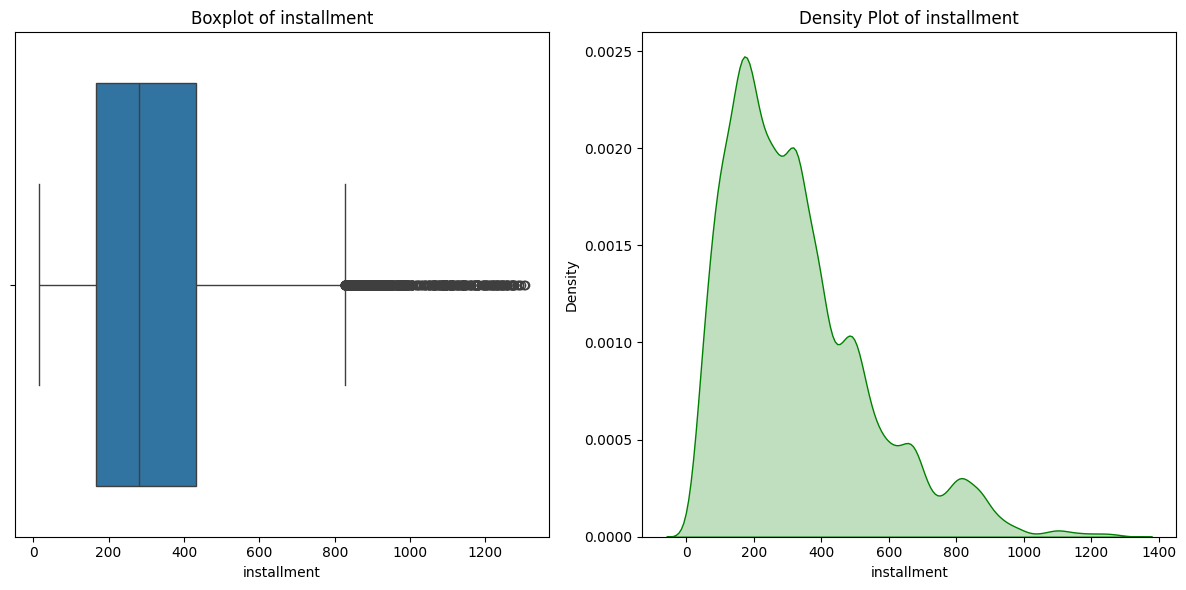

In [183]:
# Boxplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Boxplot of installment')
sns.boxplot(x=df['installment'])
plt.xlabel('installment')


# Density plot
plt.subplot(1, 2, 2)
plt.title('Density Plot of installment')
sns.kdeplot(df['installment'], color = 'green', fill=True)
plt.xlabel('installment')


plt.tight_layout()
plt.show()

In [184]:
df['annual_inc'].describe().map('{:.2f}'.format)

count      39717.00
mean       68968.93
std        63793.77
min         4000.00
25%        40404.00
50%        59000.00
75%        82300.00
max      6000000.00
Name: annual_inc, dtype: object

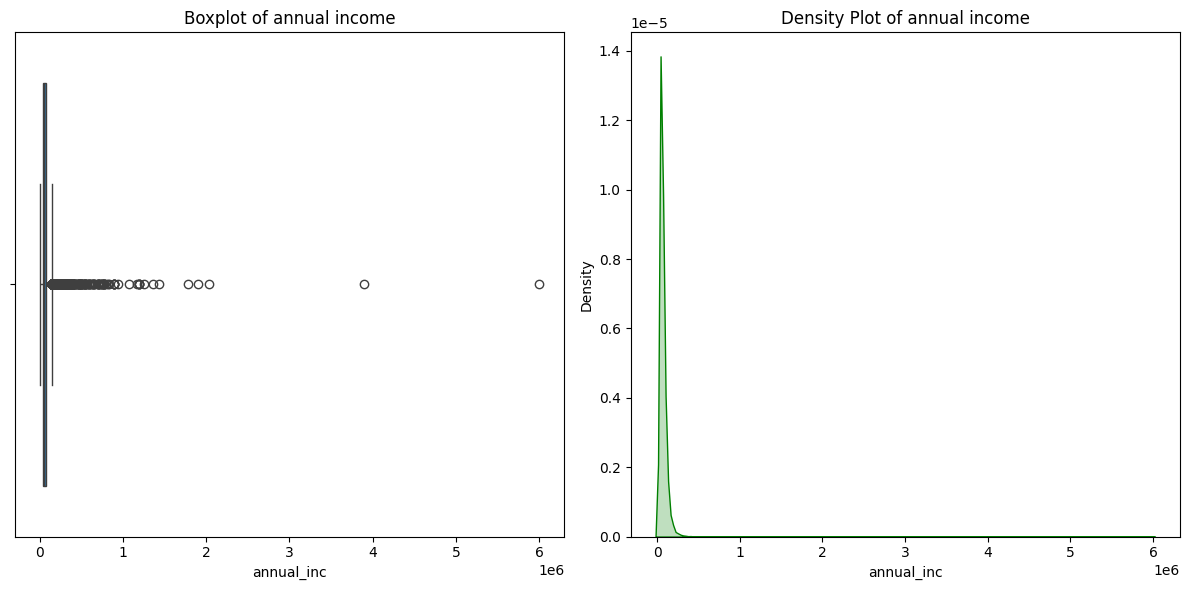

In [185]:
# Boxplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Boxplot of annual income')
sns.boxplot(x=df['annual_inc'])
plt.xlabel('annual_inc')


# Density plot
plt.subplot(1, 2, 2)
plt.title('Density Plot of annual income')
sns.kdeplot(df['annual_inc'], color = 'green', fill=True)
plt.xlabel('annual_inc')


plt.tight_layout()
plt.show()

**Nhận xét nhanh:**

*  Biến `installment` có một lượng lớn các giá trị ngoại lai bằng chứng là trung bình (mean = 324.56) cách khá xa trung bị (median = 280.22) vì bị nhiều giá trị lớn "kéo" làm cho lệch phải.
*  Biến `annual_inc` có một vài điểm ngoại lai có giá trị rất lớn, làm phân phối bị lệch phải nặng.

⇒ Ta sẽ loại bỏ một vài giá trị ngoại lai trên để các biến có phân phối gần phân phối chuẩn hơn.

In [186]:
P = np.percentile(df['installment'], [5, 95])
df = df[(df['installment'] >= P[0]) & (df['installment'] <= P[1])]
df['installment'].describe()

count    35745.000000
mean       308.709751
std        161.657521
min         71.250000
25%        176.510000
50%        280.220000
75%        406.510000
max        762.950000
Name: installment, dtype: float64

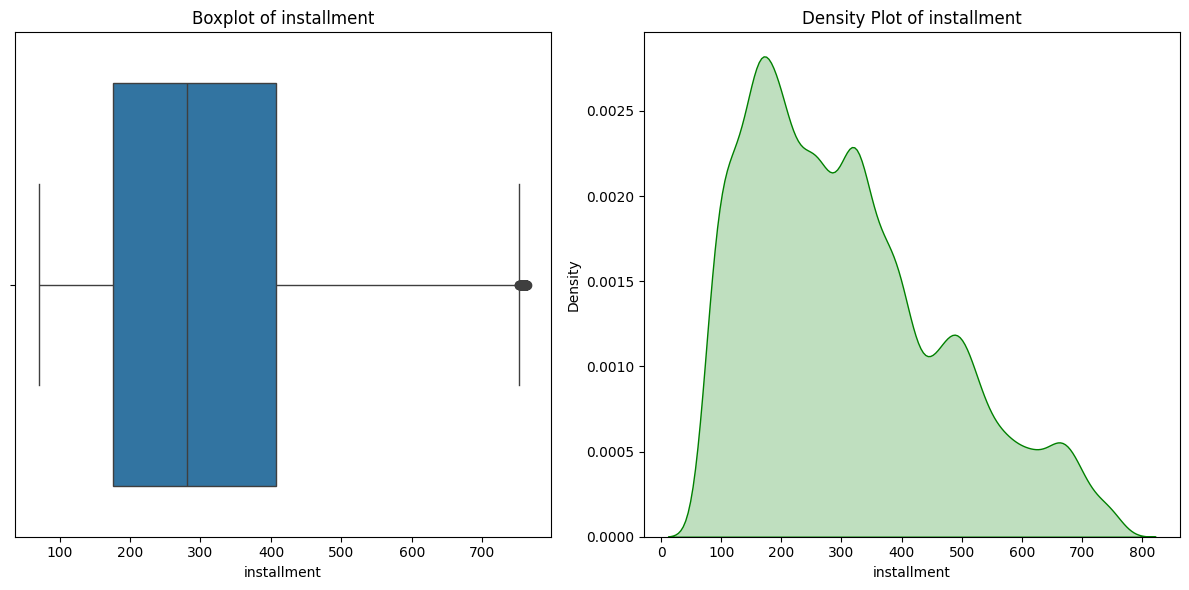

In [187]:
# Boxplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Boxplot of installment')
sns.boxplot(x=df['installment'])
plt.xlabel('installment')


# Density plot
plt.subplot(1, 2, 2)
plt.title('Density Plot of installment')
sns.kdeplot(df['installment'], color = 'green', fill=True)
plt.xlabel('installment')


plt.tight_layout()
plt.show()

In [188]:
P = np.percentile(df['annual_inc'], [5, 95])
df = df[(df['annual_inc'] >= P[0]) & (df['annual_inc'] <= P[1])]
df['annual_inc'].describe()

count     32185.000000
mean      62355.944193
std       25138.963967
min       24500.000000
25%       42016.000000
50%       58000.000000
75%       77700.000000
max      135000.000000
Name: annual_inc, dtype: float64

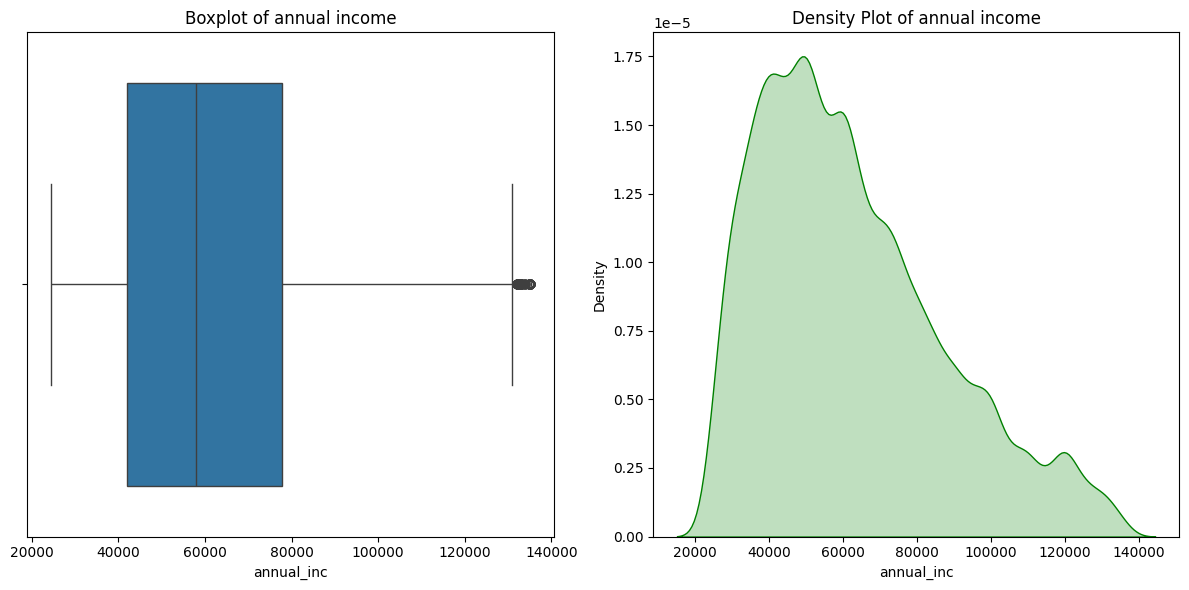

In [189]:
# Boxplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Boxplot of annual income')
sns.boxplot(x=df['annual_inc'])
plt.xlabel('annual_inc')


# Density plot
plt.subplot(1, 2, 2)
plt.title('Density Plot of annual income')
sns.kdeplot(df['annual_inc'], color = 'green', fill=True)
plt.xlabel('annual_inc')


plt.tight_layout()
plt.show()

In [190]:
check_df(df)

------------------------------- SHAPE --------------------------------
Rows: 32185
Columns: 60
------------------------------- TYPES --------------------------------
loan_amnt                                  int64
funded_amnt                                int64
funded_amnt_inv                          float64
term                                       int32
int_rate                                 float64
installment                              float64
sub_grade                                  int32
emp_length                                 int32
annual_inc                               float64
issue_d                                period[M]
loan_status                               object
purpose                                    int32
dti                                      float64
delinq_2yrs                                int64
earliest_cr_line                       period[M]
inq_last_6mths                             int64
mths_since_last_delinq                   float64
m

#### Xử lý các giá trị khuyết

In [191]:
print(' MISSING VALUES '.center(70, '-'))
print(df.isnull().sum())

--------------------------- MISSING VALUES ---------------------------
loan_amnt                                  0
funded_amnt                                0
funded_amnt_inv                            0
term                                       0
int_rate                                   0
installment                                0
sub_grade                                  0
emp_length                                 0
annual_inc                                 0
issue_d                                    0
loan_status                                0
purpose                                    0
dti                                        0
delinq_2yrs                                0
earliest_cr_line                           0
inq_last_6mths                             0
mths_since_last_delinq                 20750
mths_since_last_record                 29874
open_acc                                   0
pub_rec                                    0
revol_bal                    

**Nhận xét nhanh:**
*  Các biến `mths_since_last_delinq` và `mths_since_last_record` lần lượt bị khuyết **64.47%** và **92.82%** lượng dữ liệu. Ngoài ra, 2 biến này cũng là 2 biến numerical nên không thể xử lý giống biến categorical ở trên, nên ta có thể loại bỏ các biến này.
*  Các biến `last_credit_pull_d`, `revol_util`, `last_pymnt_d` và `pub_rec_bankruptcies` bị khuyết khá ít, lần lượt là ~0%, ~0%, 0.12% và 1.66% nên ta có thể xóa các quan trắc này mà không bị thay đổi quá nhiều phân phối của bộ dữ liệu.

In [192]:
df.drop(['mths_since_last_delinq', 'mths_since_last_record'], axis=1, inplace=True)

In [193]:
df = df.dropna()

In [194]:
print(' MISSING VALUES '.center(70, '-'))
print(df.isnull().sum())

--------------------------- MISSING VALUES ---------------------------
loan_amnt                              0
funded_amnt                            0
funded_amnt_inv                        0
term                                   0
int_rate                               0
installment                            0
sub_grade                              0
emp_length                             0
annual_inc                             0
issue_d                                0
loan_status                            0
purpose                                0
dti                                    0
delinq_2yrs                            0
earliest_cr_line                       0
inq_last_6mths                         0
open_acc                               0
pub_rec                                0
revol_bal                              0
revol_util                             0
total_acc                              0
out_prncp                              0
out_prncp_inv              

## 3. Exploratory Data Analysis (EDA)

**Kiểm tra phân bố các lớp của biến mục tiêu `loan_status`.**

<Axes: xlabel='loan_status', ylabel='Count'>

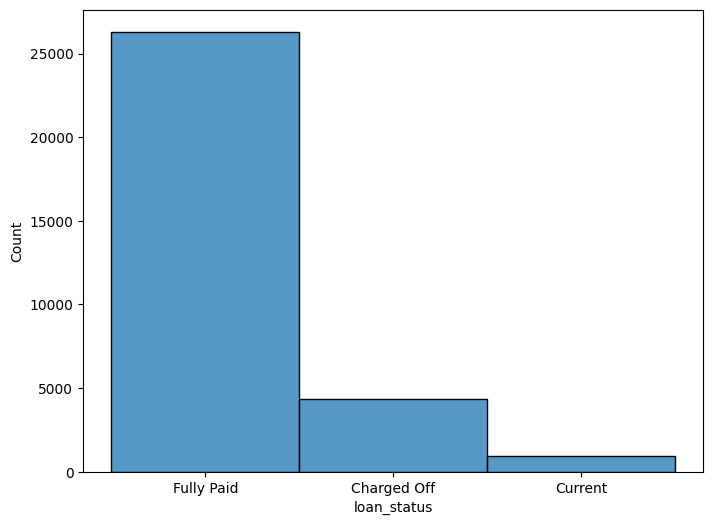

In [195]:
plt.figure(figsize=(8, 6))
sns.histplot(df['loan_status'])

**Nhận xét chung:**

Biến mục tiêu `loan_status` có 3 giá trị là:
*  `Fully Paid`: Người vay này đã thanh toán toàn bộ khoản vay, bao gồm cả gốc và lãi, theo đúng điều khoản vay.
*  `Current`: Người vay đang trả nợ đúng hạn tại thời điểm hiện tại.
*  `Charged Off`: Người vay không trả nợ trong một khoảng thời gian dài, nợ xấu dẫn tới người cho vay đã từ bỏ việc thu hồi khoản nợ.

⇒ Ta đang muốn xây dựng 1 mô hình phân loại các khách hàng nên/không nên cho vay, chính vì vậy ta sẽ gộp những người có thái độ trả nợ tốt `Fully Paid`, `Current` thành nhóm `Accept` - tức nên cho vay - và những người có thái độ trả nợ không tốt `Charged Off` thành nhóm `Reject` - tức không nên cho vay.

⇒ Ta sẽ encode `Accept` tương ứng với 1 và `Reject` tương ứng với 0.

**Về imbalanced data:** Có sự không cân bằng giữa các lớp, điều này có thể dẫn tới việc một lớp chiếm ưu thế hơn hẳn lớp còn lại. Tuy nhiên, ta sẽ thử xây dựng các mô hình trước để xem việc chiếm ưu thế của một lớp có xảy ra không. Nếu có, ta sẽ phải tìm một cách xử lý. Nếu kết quả cho ra tốt và không có biểu hiện của việc bị chiếm ưu thế của một lớp, ta có thể bỏ qua việc xử lý sự không cân bằng giữa các lớp này.


In [196]:
df['loan_status'] = df['loan_status'].apply(
    lambda x: 1 if (x == 'Fully Paid' or x == 'Current') else 0)

In [197]:
df['loan_status'].value_counts()

loan_status
1    27254
0     4333
Name: count, dtype: int64

**Loại bỏ các biến có kiểu dữ liệu là Period vì các thư viện sử dụng để phân tích không hỗ trợ xử lý kiểu dữ liệu này.**

In [198]:
period_columns = df.select_dtypes(include=['period[M]']).columns

In [199]:
X = df.drop(columns=['loan_status'] + list(period_columns))
y = df['loan_status']

**Trực quan hóa tương quan giữa các feature và biến mục tiêu `loan_status`.**

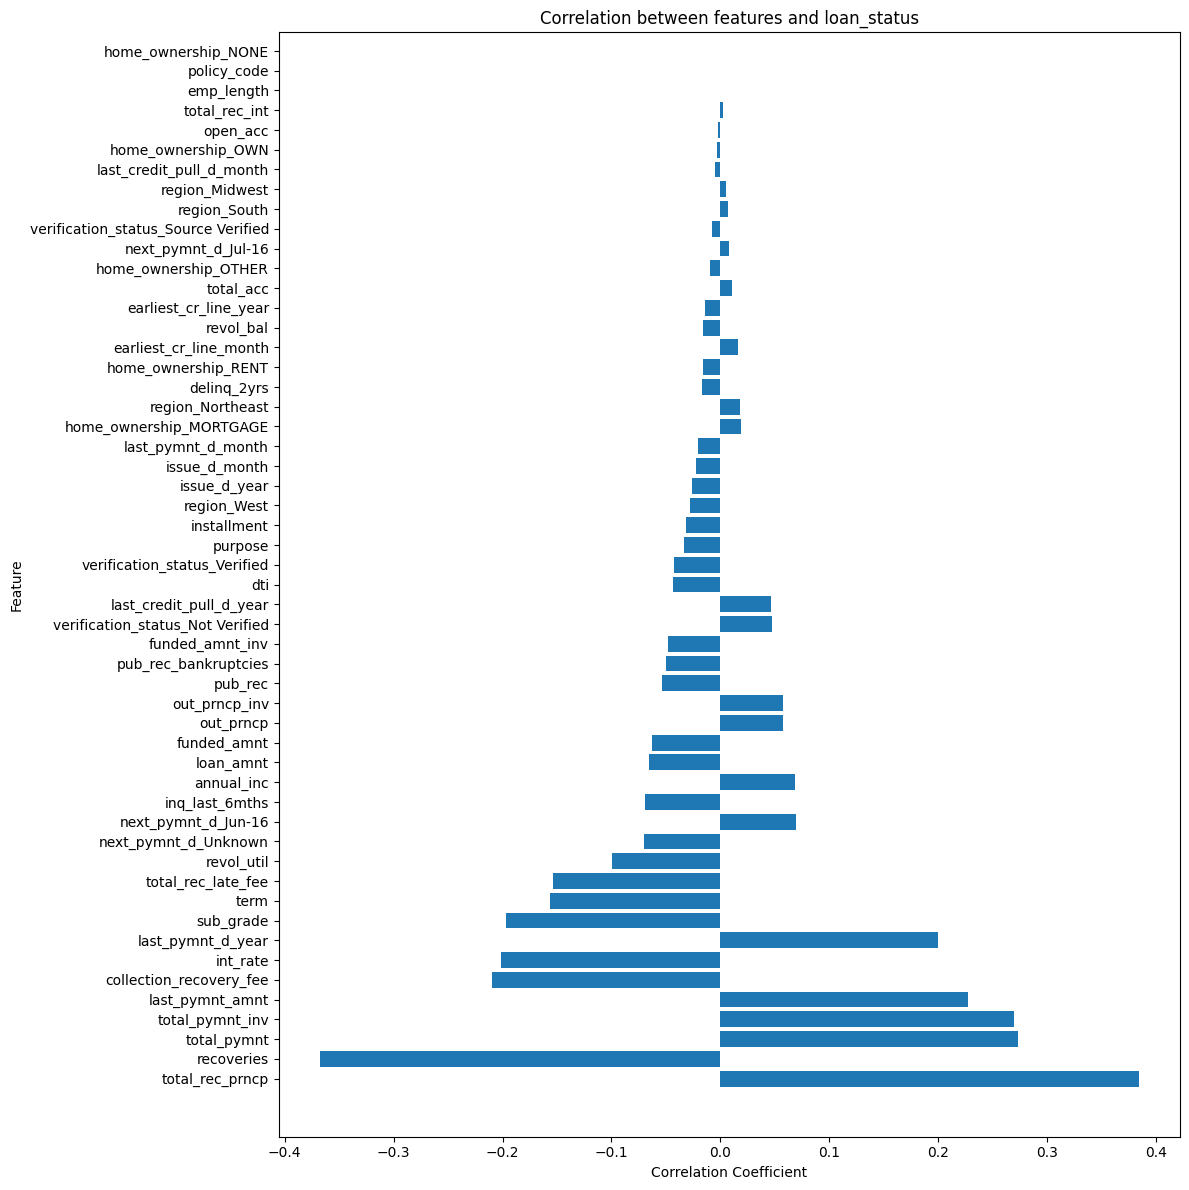

In [200]:
correlation_matrix = df.drop(columns=list(period_columns)).corr()
correlation_coef = correlation_matrix['loan_status'].drop('loan_status')
features = X.columns

loan_status_correlations = pd.DataFrame({
    'Feature': features,
    'Correlation': correlation_coef
})

# Select correlations with 'loan_status'
loan_status_correlations['Abs Correlation'] = np.abs(
    loan_status_correlations['Correlation'])
loan_status_correlations_sorted = loan_status_correlations.sort_values(
    by='Abs Correlation', ascending=False)

# Plot the correlations
plt.figure(figsize=(12, 12))
plt.barh(loan_status_correlations_sorted['Feature'],
         loan_status_correlations_sorted['Correlation'])
plt.title('Correlation between features and loan_status')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**Nhận xét nhanh:**

*  Không có biến nào có tương quan mạnh (>0,5) với biến mục tiêu `loan_status`. 
*  Tuy có tới 53 biến đặc trưng (feature) nhưng chỉ có khoảng 10-11 biến có tương quan đáng chú ý với biến mục tiêu `loan_status` gồm: `recoveries`, `total_rec_prncp`, `total_pymnt`, `total_pymnt_inv`, `last_pymnt_amnt`, `last_pymnt_d_year`, `collection_recovery_fee`, `int_rate`, `sub_grade`, `total_rec_late_fee`, `term`.

⇒ Ta dự doán có thể các mô hình chỉ cần dựa vào khoảng 10 biến này để đạt được kết quả không quá khác biệt so với sử dụng cả 53 biến. Từ đó, ta có thể sẽ thiết kế được một mô hình mới đơn giản hơn với hiệu quả tương đương.

**Dùng PCA để trực quan hóa phân phối của bộ dữ liệu.**

In [201]:
numerical_features = X.select_dtypes(include=np.number)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_features)

In [202]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_data)

In [203]:
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
pca_df['loan_status'] = df['loan_status'].values

In [204]:
fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='loan_status',
                    title='PCA 3D Scatter Plot of Loan Status Classes')

fig.show()

**Nhận xét nhanh:**

*  Từ đồ thị phân tán, ta dễ thấy 2 lớp `Accept` và `Reject` của lớp `loan_status` được chia thành 2 phần tách biệt nhau rất rõ ràng.

⇒ Đây là một tín hiệu tốt, ta kỳ vọng các mô hình có thể phân loại tốt 2 lớp với bộ dữ liệu này. Thậm chí, các mô hình có thể không cần quá phức tạp để có thể phân loại tốt 2 lớp trên.

### Train - Test Split

In [205]:
TRAIN_SIZE = 0.8

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=TRAIN_SIZE, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, train_size=TRAIN_SIZE, random_state=0)

In [206]:
X_train.shape, X_valid.shape, X_test.shape

((20215, 53), (5054, 53), (6318, 53))

### Chuẩn hóa dữ liệu

In [207]:
df.describe().T.map('{:.2f}'.format)

count      mean       std       min       25%  \
loan_amnt                 31587.00  10868.17   6076.62   2000.00   6000.00   
funded_amnt               31587.00  10579.83   5725.37   2000.00   6000.00   
funded_amnt_inv           31587.00  10179.96   5705.53      0.00   5750.00   
term                      31587.00      0.28      0.45      0.00      0.00   
int_rate                  31587.00      0.12      0.04      0.05      0.09   
installment               31587.00    310.85    158.61     71.28    183.28   
sub_grade                 31587.00      9.72      6.68      0.00      4.00   
emp_length                31587.00      4.14      3.31      0.00      1.00   
annual_inc                31587.00  62406.80  25134.19  24500.00  42294.00   
loan_status               31587.00      0.86      0.34      0.00      1.00   
purpose                   31587.00      3.74      3.37      0.00      2.00   
dti                       31587.00     13.63      6.62      0.00      8.59   
delinq_2yrs               31587.00      0.14      0.49      0.00      0.00   
inq_last_6mths            31587.00      0.86      1.06      0.00      0.00   
open_acc                  31587.00      9.36      4.30      2.00      6.00   
pub_rec                   31587.00      0.06      0.24      0.00      0.00   
revol_bal                 31587.00  12516.30  13341.60      0.00   4066.00   
revol_util                31587.00      0.49      0.28      0.00      0.26   
total_acc                 31587.00     22.18     11.04      2.00     14.00   
out_prncp                 31587.00     48.76    337.20      0.00      0.00   
out_prncp_inv             31587.00     48.55    336.01      0.00      0.00   
total_pymnt               31587.00  11737.04   7389.43     91.89   6066.59   
total_pymnt_inv           31587.00  11300.56   7330.47      0.00   5784.15   
total_rec_prncp           31587.00   9495.50   5777.10      0.00   5000.00   
total_rec_int             31587.00   2156.96   2224.59     11.64    734.06   
total_rec_late_fee        31587.00      1.15      6.23      0.00      0.00   
recoveries                31587.00     83.43    568.88      0.00      0.00   
collection_recovery_fee   31587.00     10.16    121.72      0.00      0.00   
last_pymnt_amnt           31587.00   2594.78   3994.16      0.01    240.40   
policy_code               31587.00      1.00      0.00      1.00      1.00   
pub_rec_bankruptcies      31587.00      0.05      0.21      0.00      0.00   
earliest_cr_line_year     31587.00   1996.88      7.17   1969.00   1994.00   
earliest_cr_line_month    31587.00      6.89      3.54      1.00      4.00   
issue_d_year              31587.00   2010.38      0.81   2007.00   2010.00   
issue_d_month             31587.00      7.21      3.37      1.00      4.00   
last_pymnt_d_year         31587.00   2012.89      1.50   2008.00   2012.00   
last_pymnt_d_month        31587.00      6.45      3.42      1.00      3.00   
last_credit_pull_d_year   31587.00   2014.36      1.73   2008.00   2013.00   
last_credit_pull_d_month  31587.00      5.80      3.01      1.00      4.00   

                               50%       75%        max  
loan_amnt                 10000.00  15000.00   35000.00  
funded_amnt               10000.00  14400.00   35000.00  
funded_amnt_inv            9375.00  13950.00   35000.00  
term                          0.00      1.00       1.00  
int_rate                      0.12      0.14       0.24  
installment                 285.29    406.80     762.08  
sub_grade                     9.00     14.00      34.00  
emp_length                    3.00      6.00      11.00  
annual_inc                58000.00  78000.00  135000.00  
loan_status                   1.00      1.00       1.00  
purpose                       2.00      6.00      13.00  
dti                          13.76     18.85      29.99  
delinq_2yrs                   0.00      0.00      11.00  
inq_last_6mths                1.00      1.00       8.00  
open_acc                      9.00    

Vì các biến đặc trưng nằm trong nhiều khoảng giá trị khác nhau nên ta sẽ chuẩn hóa để đưa chúng về gần nhau hơn.

In [208]:
scaler = StandardScaler()

scaler.fit(X_train)
for dataframe in [X_train, X_valid, X_test]:
    scaled_values = scaler.transform(dataframe)
    scaled_df = pd.DataFrame(
        scaled_values, columns=dataframe.columns, index=dataframe.index)
    dataframe = scaled_df

## 4. Model Development

### Logistic Regression

In [209]:
start_time = time.time()

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

end_time = time.time()
lr_train_time = end_time - start_time

c:\Users\admin\anaconda3\envs\gan\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [210]:
y_pred_lr = lr_model.predict(X_test)

In [211]:
print("AUC-ROC (Logistic Regression):", roc_auc_score(y_test, y_pred_lr))

AUC-ROC (Logistic Regression): 0.9999086424264572


In [212]:
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       845
           1       1.00      1.00      1.00      5473

    accuracy                           1.00      6318
   macro avg       1.00      1.00      1.00      6318
weighted avg       1.00      1.00      1.00      6318



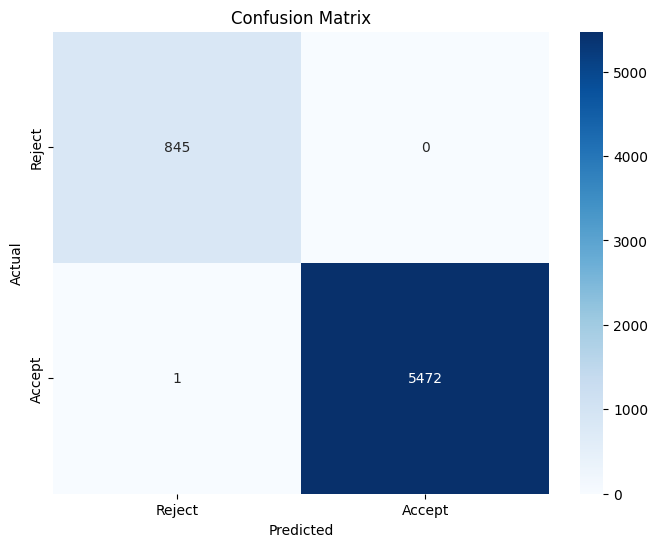

In [213]:
conf_matrix = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Reject', 'Accept'],
            yticklabels=['Reject', 'Accept'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Decision Tree

In [214]:
start_time = time.time()

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

end_time = time.time()
dt_train_time = end_time - start_time

In [215]:
y_pred_dt = dt_model.predict(X_test)

In [216]:
print("AUC-ROC (Decision Tree):", roc_auc_score(y_test, y_pred_dt))

AUC-ROC (Decision Tree): 0.9804691562776708


In [217]:
print("Decision Tree - Classification Report:")
print(classification_report(y_test, y_pred_dt))

Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       845
           1       0.99      1.00      1.00      5473

    accuracy                           0.99      6318
   macro avg       0.99      0.98      0.98      6318
weighted avg       0.99      0.99      0.99      6318



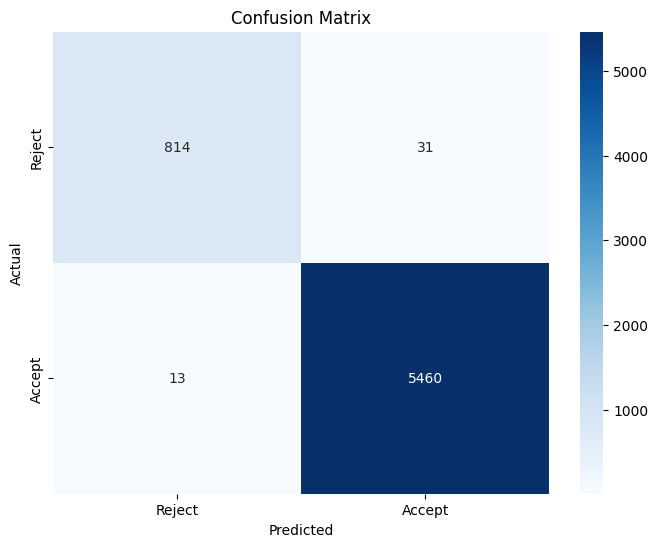

In [218]:
conf_matrix = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Reject', 'Accept'],
            yticklabels=['Reject', 'Accept'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Gradient Boosting

In [219]:
X_train_gbm = X_train
X_valid_gbm = X_valid
X_test_gbm = X_test

In [220]:
categorical_features = ['term', 'sub_grade', 'emp_length', 'purpose']

for col in categorical_features:
    X_train_gbm[col] = X_train_gbm[col].astype('category')

for col in categorical_features:
    X_valid_gbm[col] = X_valid_gbm[col].astype('category')

for col in categorical_features:
    X_test_gbm[col] = X_test_gbm[col].astype('category')

In [221]:
lgb_train = lgb.Dataset(
    X_train_gbm, y_train,
    categorical_feature=categorical_features,
    free_raw_data=False,
)

lgb_valid = lgb.Dataset(
    X_valid_gbm, y_valid,
    categorical_feature=categorical_features,
    free_raw_data=False,
    reference=lgb_train,
)

In [222]:
params = {
    "objective": "binary",
    "num_iterations": 3000,
    "metric": ["auc", "binary_logloss"],
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 4,
    "max_depth": 4,
    "num_threads": 4,
    "tree_learner": "serial",
    # "lambda_l2": 0.05,
    # "path_smooth": 128,
    "early_stopping_round": 200,
    "feature_pre_filter": False,
    "first_metric_only": True,
}

In [223]:
start_time = time.time()

gbm_model = lgb.train(
    params,
    train_set=lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    callbacks=[
        lgb.early_stopping(100, first_metric_only=True),
        lgb.log_evaluation(50, show_stdv=True)
    ]
)

end_time = time.time()
gbm_train_time = end_time - start_time

c:\Users\admin\anaconda3\envs\gan\lib\site-packages\lightgbm\engine.py:204: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17434, number of negative: 2781
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5017
[LightGBM] [Info] Number of data points in the train set: 20215, number of used features: 52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.862429 -> initscore=1.835612
[LightGBM] [Info] Start training from score 1.835612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

In [224]:
y_pred = gbm_model.predict(X_test_gbm)
y_pred_gbm = (y_pred > 0.5).astype(int)

In [225]:
print("AUC-ROC (Gradient Boosting):", roc_auc_score(y_test, y_pred_gbm))

AUC-ROC (Gradient Boosting): 0.9923076923076923


In [226]:
print("Gradient Boosting - Classification Report:")
print(classification_report(y_test, y_pred_gbm))

Gradient Boosting - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       845
           1       1.00      1.00      1.00      5473

    accuracy                           1.00      6318
   macro avg       1.00      0.99      1.00      6318
weighted avg       1.00      1.00      1.00      6318



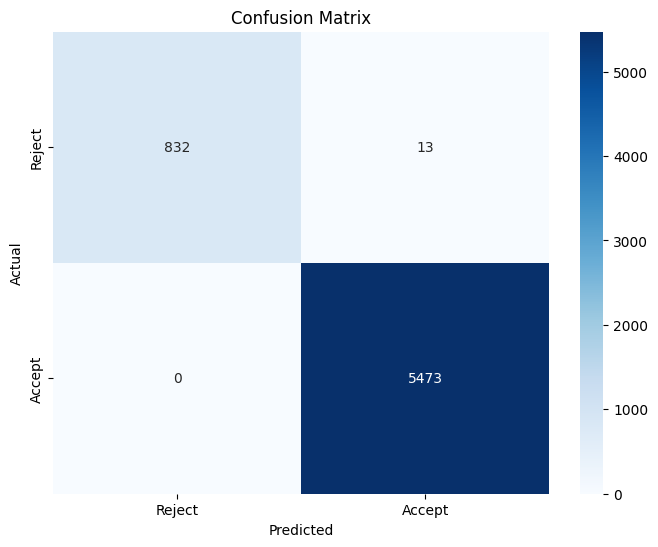

In [227]:
conf_matrix = confusion_matrix(y_test, y_pred_gbm)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Reject', 'Accept'],
            yticklabels=['Reject', 'Accept'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### So sánh kết quả giữa các mô hình

In [228]:
metrics = {
    'Model': ['Decision Tree', 'Logistic Regression', 'Gradient Boosting'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_gbm),
    ],
    'Precision': [
        precision_score(y_test, y_pred_dt, average='weighted'),
        precision_score(y_test, y_pred_lr, average='weighted'),
        precision_score(y_test, y_pred_gbm, average='weighted'),
    ],
    'Recall': [
        recall_score(y_test, y_pred_dt, average='weighted'),
        recall_score(y_test, y_pred_lr, average='weighted'),
        recall_score(y_test, y_pred_gbm, average='weighted'),
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_dt, average='weighted'),
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred_gbm, average='weighted'),
    ],
    'AUC-ROC': [
        roc_auc_score(y_test, y_pred_dt),
        roc_auc_score(y_test, y_pred_lr),
        roc_auc_score(y_test, y_pred_gbm),
    ],
    'Train Time': [
        dt_train_time,
        lr_train_time,
        gbm_train_time,
    ],
}

metrics_df = pd.DataFrame(metrics)
display(metrics_df)

Model  Accuracy  Precision    Recall  F1 Score   AUC-ROC  \
0        Decision Tree  0.993036   0.993007  0.993036  0.993004  0.980469   
1  Logistic Regression  0.999842   0.999842  0.999842  0.999842  0.999909   
2    Gradient Boosting  0.997942   0.997947  0.997942  0.997936  0.992308   

   Train Time  
0    0.277485  
1    0.180520  
2    1.965021

**Nhận xét tổng quan:**

*  Cả 3 mô hình đều cho ra kết quả rất tốt mặc dù chưa hypertuning, cả 4 metric `accuracy`, `precision`, `recall` và `F1 score` đều trên 0.99 và chỉ có AUC của mô hình Decision Tree đạt dưới 0.99 - là 0.98. Điều này cho thấy các mô hình trên là phù hợp với bộ dữ liệu hiện tại, đồng thời ảnh hưởng của việc không cân bằng giữa 2 lớp cần phân loại gần như không có.
*  Dù có chênh lệch về metric giữa các mô hình nhưng chỉ rất nhỏ, trong khoảng 0.019 cho AUC và khoảng 0.007 cho các metric còn lại.
*  Nổi trội nhất có thể thấy là mô hình Logistic Regression với sự thời gian Train thấp nhất nhưng tất cả các metrics đều cao nhất trong cả 3 mô hình. Điều này giống với những gì ta kỳ vọng khi quan sát bộ dữ liệu ở trên (Bộ dữ liệu đã phân tách khá tốt nên có thể một phương pháp đơn giản, truyền thống cũng có thể đạt được kết quả tốt).

⇒ Ta sẽ chọn Logistic Regression là kiến trúc để thiết kế lại một mô hình mới với ít feature hơn, đơn giản hơn dựa trên các phân tích feature importance ở dưới. Đồng thời, sẽ hypertuning và tạo một script để dự doán các khách hàng mới trong tương lai.

## 5. Explainability

**Các biến từ mô hình Logistic Regression.**

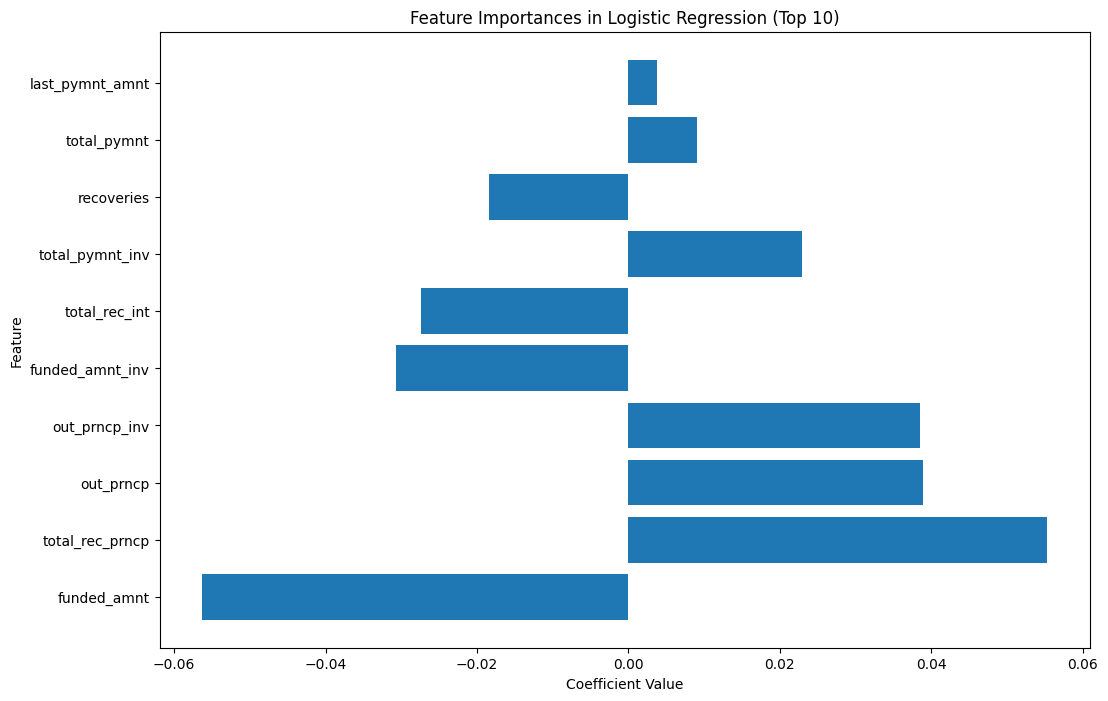

In [229]:
coefficients = lr_model.coef_[0]  # Access coefficients for feature importance
feature_names = X_train.columns

feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients,
    'Odds Ratio': np.exp(coefficients)
})

# Sort by absolute value of coefficient to get the most important features
feature_importance['Abs Coefficient'] = np.abs(
    feature_importance['Coefficient'])
feature_importance_sorted = feature_importance.sort_values(
    by='Abs Coefficient', ascending=False)

# Plotting the feature importances (Coefficients)
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_sorted['Feature'].head(
    10), feature_importance_sorted['Coefficient'].head(10))
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importances in Logistic Regression (Top 10)')
plt.show()

**Các biến từ mô hình Decision Tree.**

In [230]:
importances = dt_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame(
    {'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=True)

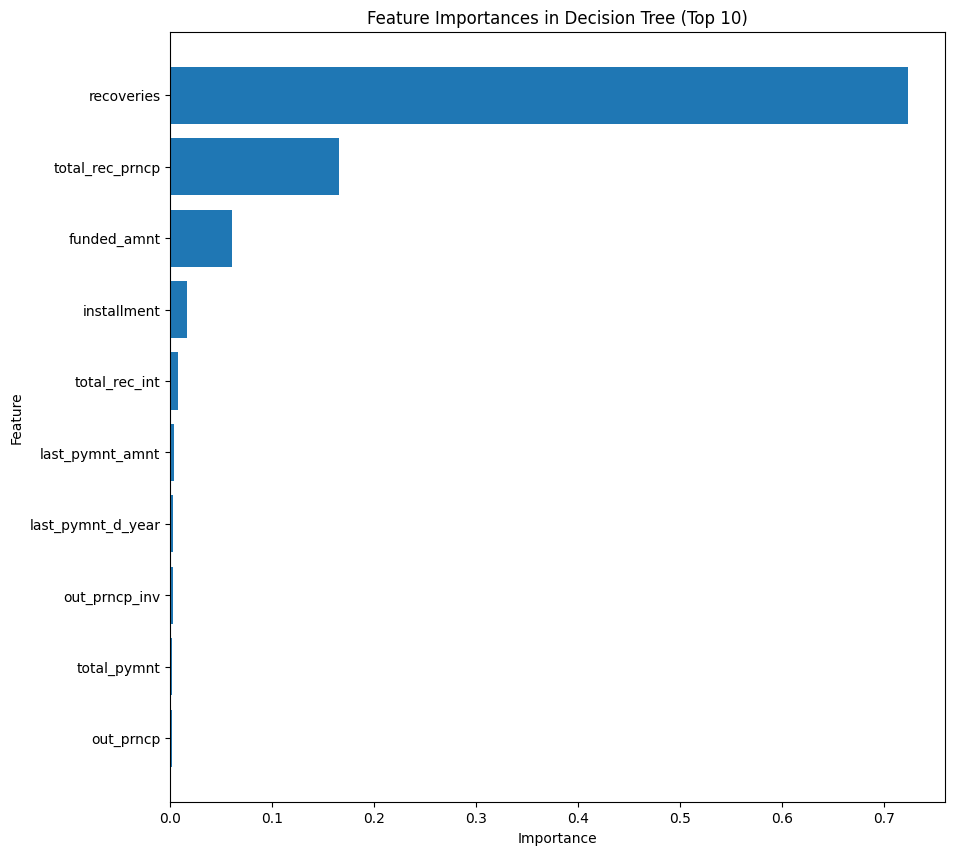

In [231]:
plt.figure(figsize=(10, 10))
plt.barh(importance_df['Feature'].tail(10),
         importance_df['Importance'].tail(10))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Decision Tree (Top 10)')
plt.show()

In [232]:
recoveries_accept = df['recoveries'][df['loan_status'] == 1]
recoveries_accept.value_counts()

recoveries
0.0    27254
Name: count, dtype: int64

In [233]:
recoveries_reject = df['recoveries'][df['loan_status'] == 0]
recoveries_reject.value_counts()

recoveries
0.00       1090
11.29         4
16.50         3
14.61         3
12.09         3
           ... 
1366.13       1
311.57        1
17.53         1
222.17        1
304.20        1
Name: count, Length: 3125, dtype: int64

**Các biến từ mô hình Gradient Boosting.**

c:\Users\admin\anaconda3\envs\gan\lib\site-packages\shap\explainers\_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



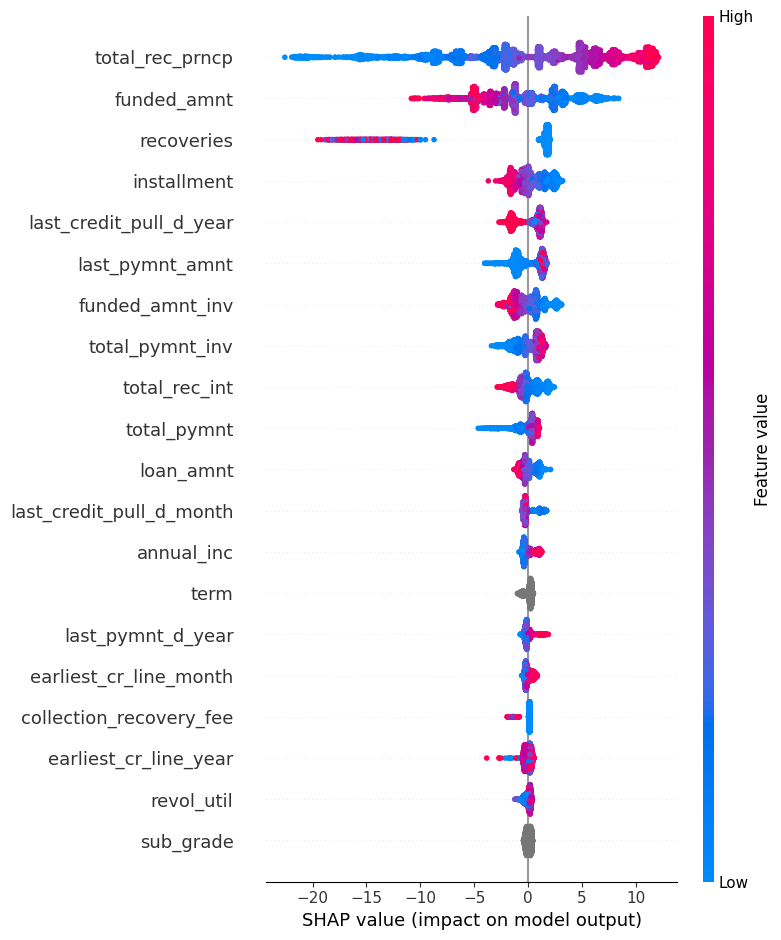

In [234]:
explainer = shap.TreeExplainer(gbm_model)
shap_values = explainer.shap_values(X_valid_gbm)

shap.summary_plot(shap_values, X_valid_gbm)

**Nhận xét tổng quan:**

*  Trong mô hình **Logistic Regression**, các biến có tác động lớn là:
    *  `funded_amnt`: Có hệ số âm lớn nhất, cho thấy khi số tiền được cấp (funded_amnt) càng cao, khả năng được duyệt khoản vay sẽ càng giảm. Điều này đúng với thực tế vì khoản vay càng lớn sẽ càng khó được cho vay.
    *  `total_rec_prncp`: Có hệ số dương mạnh, cho thấy khi số tiền gốc đã trả càng cao, khả năng được duyệt khoản vay sẽ càng tăng. Điều này đúng với thực tế vì người vay trả nợ càng nhiều thì uy tín của họ càng cao, tỉ lệ được cho vay tiếp càng cao.
    *  `out_prncp` và `out_prncp_inv`: Hai đặc trưng này tượng trưng cho số tiền gốc còn phải trả cho bên cho vay - cũng có hệ số dương, nghĩa là khi giá trị này tăng lên, khả năng xảy ra sự kiện sẽ tăng. Tuy nhiên, vì bộ dữ liệu này ghi nhận 2 giá trị này bằng 0 khi khách hàng `Charged Off` (không trả nợ) - giống với khi khách hàng `Fully Paid` (trả hết nợ) - và chỉ có khách hàng nào đang trả nợ `Current` mới có 2 giá trị này lớn hơn 0. Điều này dẫn tới tuy có hệ số cao nhưng 2 biến này chỉ dự đoán được các khách hàng `Current`, nếu bên ngoài tệp khách hàng đó 2 biến này sẽ không có ích.
    *  Các biến `funded_amnt_inv`, `total_rec_int`, `total_pymnt_inv` và `recoveries` có hệ số tương ứng giảm dần, tuy không lớn nhưng cũng hơn rất nhiều so với hệ số của các biến trở về sau.
*  Trong mô hình **Decision Tree**, các biến có tác động lớn là:
    *  `recoveries`: Là đặc trưng quan trọng nhất, có mức độ ảnh hưởng lớn hơn nhiều so với các đặc trưng còn lại. Tuy nhiên, biến này là số tiền thu hồi được sau khi xóa nợ (hay số tiền bị đòi nợ sau khi trốn nợ), tức là nếu biến này có giá trị dương thì chắc chắn khách hàng này đã trốn nợ - `Charged Off`, còn nếu biến này có giá trị bằng 0 thì tỉ lệ rất cao là khách hàng đã trả nợ `Fully Paid` hoặc đang trả nợ `Current`. Minh chứng là có tới 33477 giá trị 0 và là giá trị duy nhất ở lớp `Accept` và chỉ có 1347 giá trị 0 ở lớp `Reject`.
    *  `total_rec_prncp`: Là đặc trưng quan trọng thứ hai. Gợi ý rằng tổng số tiền gốc đã trả (total_rec_prncp) cũng là một yếu tố dự đoán mạnh. Điều này đúng với thực tế và giống với của mô hình Logistic Regression.
    *  `funded_amnt`: Là đặc trưng quan trọng thứ ba. Cho thấy tổng số tiền đã được cấp (funded_amnt) có ảnh hưởng đáng kể đến dự đoán. Điều này đúng với thực tế và giống với của mô hình Logistic Regression.
*  Trong mô hình **Gradient Boosting**, các biến có tác động lớn là:
    *  `total_rec_prncp`: Là đặc trưng quan trọng nhất. Các giá trị SHAP màu đỏ đều là giá trị dương, tức là số tiền gốc đã trả càng lớn thì tỉ lệ duyệt đơn xin vay càng tăng. Điều này là đúng với thực tế và giống với phân tích ở phần Logistic Regression.
    *  `recoveries`: Quan trọng thứ hai. Các giá trị SHAP màu đỏ đều là giá trị âm, tức là số tiền thu hồi được sau khi xóa nợ càng lớn thì tỉ lệ duyệt đơn xin vay càng giảm. Điều này là đúng và phù hợp với phân tích ở phần Decision Tree.
    *  `funded_amnt`: Là đặc trưng quan trọng thứ ba. Các giá trị SHAP màu đỏ đều là giá trị âm, tức là số tiền được cấp/xin vay càng lớn thì tỉ lệ duyệt đơn xin vay càng giảm. Điều này là đúng với thực tế và giống với phân tích ở phần Logistic Regression.

Nhìn chung, các biến có tác động lớn nhất xuất hiện trong cả 3 mô hình là `funded_amnt` (số tiền được cấp/xin vay) và `total_rec_prncp` (số tiền gốc đã trả). Trong thực tế, hai yếu tố trên cũng đóng một phần quan trọng trong quyết định cho vay nên ta có thể coi các mô hình đã huấn luyện cho ra kết quả hợp lý với thực tiễn, có thể giải thích được.

Ngoài ra, để xây dựng một mô hình mới đơn giản hơn, ở trên ta đã chọn mô hình Logistic Regression nên bây giờ ta sẽ chọn 8 biến có tác động lớn tới mô hình Logistic Regression để huấn luyện mô hình mới, gồm: `funded_amnt`, `total_rec_prncp`, `out_prncp`, `out_prncp_inv`, `funded_amnt_inv`, `total_rec_int`, `total_pymnt_inv` và `recoveries`.

## 6. Xây dựng mô hình mới

**Tạo bộ dữ liệu mới chỉ gồm 8 biến đặc trưng đã chọn và 1 biến mục tiêu.**

In [235]:
new_df = pd.DataFrame()

for feature in feature_importance_sorted['Feature'].head(8):
    new_df[feature] = df[feature]

new_df['loan_status'] = df['loan_status']

In [236]:
new_df

funded_amnt  total_rec_prncp  out_prncp  out_prncp_inv  \
3            10000         10000.00        0.0            0.0   
5             5000          5000.00        0.0            0.0   
6             7000          6985.61        0.0            0.0   
7             3000          3000.00        0.0            0.0   
8             5600           162.02        0.0            0.0   
...            ...              ...        ...            ...   
39562         4800          4800.00        0.0            0.0   
39573         7000          7000.00        0.0            0.0   
39623         9000          1496.83        0.0            0.0   
39666        15450          8688.59        0.0            0.0   
39680         3000          3000.00        0.0            0.0   

       funded_amnt_inv  total_rec_int  total_pymnt_inv  recoveries  \
3              10000.0        2214.92         12231.89        0.00   
5               5000.0         632.21          5632.21        0.00   
6               7000.0        3125.23         10110.84        0.00   
7               3000.0         939.14          3939.14        0.00   
8               5600.0         294.94           646.02      189.06   
...                ...            ...              ...         ...   
39562           1100.0         334.09          1176.56        0.00   
39573           1000.0        1174.02          1167.72        0.00   
39623            700.0         609.26           311.64     1909.87   
39666            600.0        2659.96           451.73      304.20   
39680            525.0         579.66           626.44        0.00   

       loan_status  
3                1  
5                1  
6                1  
7                1  
8                0  
...            ...  
39562            1  
39573            1  
39623            0  
39666            0  
39680            1  

[31587 rows x 9 columns]

**Train-Test split và chuẩn hóa.**

In [237]:
X_new = new_df.drop(columns=['loan_status'])
y_new = new_df['loan_status']

In [238]:
TRAIN_SIZE = 0.8

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, y_new, train_size=TRAIN_SIZE, random_state=0)

In [239]:
X_train_new.shape, X_test_new.shape

((25269, 8), (6318, 8))

In [240]:
scaler_new = StandardScaler()

X_train_new = scaler_new.fit_transform(X_train_new)
X_test_new = scaler_new.transform(X_test_new)

**Huấn luyện và hypertuning cho mô hình.**

In [241]:
model = LogisticRegression()

In [242]:
lr_param_grid = {
    'max_iter': [50, 100, 200],
    'C': [0.1, 0.5, 1, 5, 10],
    'solver': ['lbfgs', 'liblinear', 'saga']
}

grid_search = GridSearchCV(
    estimator=model, param_grid=lr_param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_new, y_train_new)

# In ra các hyperparameters tốt nhất
print(f"Best Parameters for Logistic Regression: {grid_search.best_params_}")

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best Parameters for Logistic Regression: {'C': 10, 'max_iter': 50, 'solver': 'liblinear'}


**Đánh giá mô hình mới.**

In [243]:
best_model = grid_search.best_estimator_  # Lưu lại mô hình có performance tốt nhất
y_pred = best_model.predict(X_test_new)

In [244]:
auc_score = roc_auc_score(y_test, y_pred)
print("AUC-ROC (Tuned Logistic Regression):", auc_score)

AUC-ROC (Tuned Logistic Regression): 0.9905325443786982


In [245]:
print("Tuned Logistic Regression - Classification Report:")
print(classification_report(y_test, y_pred))

Tuned Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       845
           1       1.00      1.00      1.00      5473

    accuracy                           1.00      6318
   macro avg       1.00      0.99      0.99      6318
weighted avg       1.00      1.00      1.00      6318



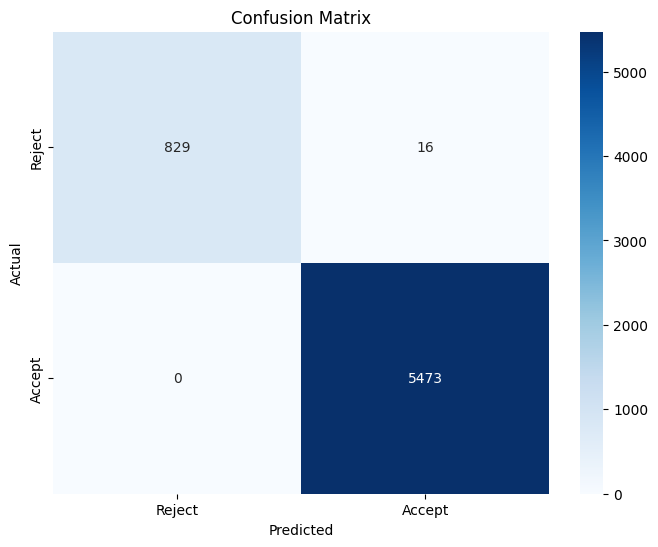

In [246]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Reject', 'Accept'],
            yticklabels=['Reject', 'Accept'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**So sánh mô hình gốc và mô hình đã đơn giản hóa.**

In [247]:
metrics = {
    'Model': ['Logistic Regression', 'Tuned Logistic Regression'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred),
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr, average='weighted'),
        precision_score(y_test, y_pred, average='weighted'),
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr, average='weighted'),
        recall_score(y_test, y_pred, average='weighted'),
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred, average='weighted'),
    ],
    'AUC-ROC': [
        roc_auc_score(y_test, y_pred_lr),
        roc_auc_score(y_test, y_pred),
    ],
}

metrics_df = pd.DataFrame(metrics)
display(metrics_df)

Model  Accuracy  Precision    Recall  F1 Score  \
0        Logistic Regression  0.999842   0.999842  0.999842  0.999842   
1  Tuned Logistic Regression  0.997468   0.997475  0.997468  0.997457   

    AUC-ROC  
0  0.999909  
1  0.990533

**Nhận xét nhanh:**

*  Với chỉ 8 biến đặc trưng, sau khi hypertuning thì các metric của mô hình Logistic Regression mới chỉ giảm khoảng 0.009 ở AUC và 0.002 ở các metric còn lại.

⇒ Với mô hình được đơn giản hóa từ 53 biến đặc trưng còn 8 biến đặc trưng nhưng hiệu suất giảm rất nhỏ thì đây là một sự thành công và ta có thể lưu lại mô hình mới này để sử dụng cho sau này.

**Lưu lại mô hình và scaler để sử dụng sau.**

In [248]:
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler_new, file)

In [249]:
model_pkl_file = "loan_classifier_model.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(grid_search.best_estimator_, file)